# Stanford hyperspectral

We took an hyperspectral image of Stanford (and SF, Berkeley, up to Sacramento, down to Salinas) few weeks ago.

Download the data from [Telluric](https://telluric.satellogic.com/catalog/scene/newsat4_macro_cube_d455bfb4f126437bb85edb3a4754e6fd_0_4_4) and place it under `data/`

In [1]:
import os
import numpy as np

hypercube_folder="./data/satellogic/"
files=os.listdir(hypercube_folder) 

hfiles=np.sort([x for x in files if x[-6:]=='nm.tif'])

print("Number of Spectral bands: %i" % (len(hfiles)))
print(hfiles)


Number of Spectral bands: 28
['HyperCube_452_nm.tif' 'HyperCube_462_nm.tif' 'HyperCube_475_nm.tif'
 'HyperCube_488_nm.tif' 'HyperCube_502_nm.tif' 'HyperCube_516_nm.tif'
 'HyperCube_530_nm.tif' 'HyperCube_550_nm.tif' 'HyperCube_570_nm.tif'
 'HyperCube_582_nm.tif' 'HyperCube_595_nm.tif' 'HyperCube_608_nm.tif'
 'HyperCube_616_nm.tif' 'HyperCube_670_nm.tif' 'HyperCube_700_nm.tif'
 'HyperCube_710_nm.tif' 'HyperCube_720_nm.tif' 'HyperCube_730_nm.tif'
 'HyperCube_740_nm.tif' 'HyperCube_750_nm.tif' 'HyperCube_760_nm.tif'
 'HyperCube_770_nm.tif' 'HyperCube_780_nm.tif' 'HyperCube_790_nm.tif'
 'HyperCube_800_nm.tif' 'HyperCube_810_nm.tif' 'HyperCube_820_nm.tif'
 'HyperCube_827_nm.tif']


In [2]:
#Read ALL bands, 
# mask them into the ROI and 
# save them into a single multiband cube
# MINIMIZE MEMORY FOOTPRINT

import fiona
import rasterio
from rasterio.mask import mask

#to mask the region we need both images in the same CRS
with fiona.open("./Stanford-SF.geojson", "r") as shapefile:
    geoms = [feature["geometry"] for feature in shapefile]

max_cast=40000
min_cast=0

with rasterio.open(hypercube_folder+hfiles[0]) as src:
    out_image, out_transform = mask(src, geoms, crop=True)
cube_dtype=np.uint8 #np.uint16 to have more spectral flux resolution.
cube=np.zeros((np.shape(out_image.data)[1], np.shape(out_image.data)[2],len(hfiles)),dtype=np.uint8)


print("Reading files...",end='')
for i in np.arange(len(hfiles[:])):
    file=hfiles[i]
    print(file,end=", "),
    with rasterio.open(hypercube_folder+file) as src:
        out_image, out_transform = mask(src, geoms, crop=True)
        if out_image.data.dtype == cube.dtype:
            cube[:,:,i]=out_image.data
        else:
            #cast to uint8, to save space
            cube[:,:,i]=((np.clip(out_image.data,min_cast,max_cast)-min_cast)/(max_cast-min_cast))*np.iinfo(cube.dtype).max
print("")

Reading files...HyperCube_452_nm.tif, HyperCube_462_nm.tif, HyperCube_475_nm.tif, HyperCube_488_nm.tif, HyperCube_502_nm.tif, HyperCube_516_nm.tif, HyperCube_530_nm.tif, HyperCube_550_nm.tif, HyperCube_570_nm.tif, HyperCube_582_nm.tif, HyperCube_595_nm.tif, HyperCube_608_nm.tif, HyperCube_616_nm.tif, HyperCube_670_nm.tif, HyperCube_700_nm.tif, HyperCube_710_nm.tif, HyperCube_720_nm.tif, HyperCube_730_nm.tif, HyperCube_740_nm.tif, HyperCube_750_nm.tif, HyperCube_760_nm.tif, HyperCube_770_nm.tif, HyperCube_780_nm.tif, HyperCube_790_nm.tif, HyperCube_800_nm.tif, HyperCube_810_nm.tif, HyperCube_820_nm.tif, HyperCube_827_nm.tif, 


<IPython.core.display.Javascript object>


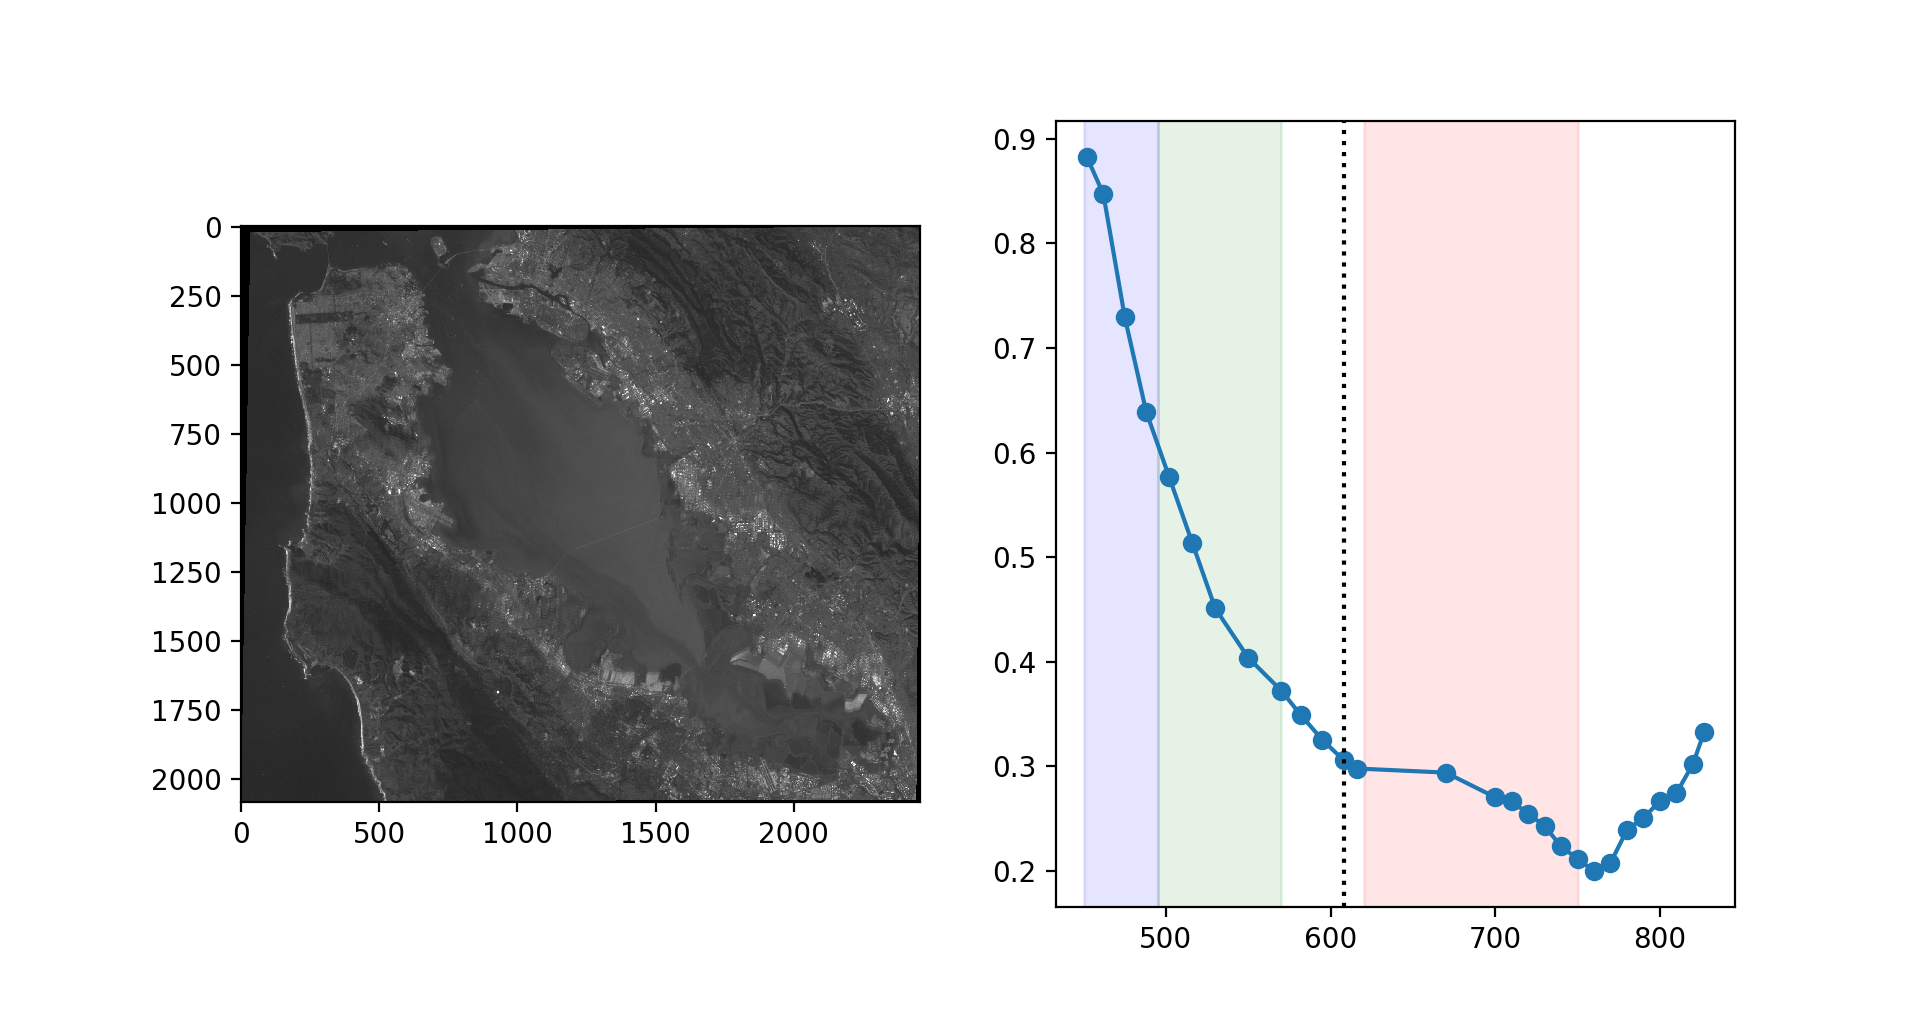

interactive(children=(IntSlider(value=14, description='Channel', max=27), Output()), _dom_classes=('widget-interact',))

In [3]:
#plot the data
%matplotlib notebook
%matplotlib notebook
from ipywidgets import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def macro_plot(c):
    wavelengths = [int(a[10:13]) for a in hfiles]

    i=int(c.shape[2]/2)    
    x=int(c.shape[0]/2)
    y=int(c.shape[1]/2)
    
    fig=plt.figure()
    im=plt.subplot(121)
    s=plt.subplot(122)

    im.cla()
    im.imshow(c[:,:,i])

    red=[620,750]
    green=[495,570]
    blue=[450,495]
    def spectra(i,x,y):
        s.cla()
        s.plot(wavelengths,c[x,y,:]/255,'o-')
        s.axvline(x=wavelengths[i],linestyle=':',color='black')
    
    #add RGB reference
        for p in [
        patches.Rectangle(
            (red[0], 0), red[1]-red[0], 1,
            alpha=.1,Color='red'
        ),
        patches.Rectangle(
            (green[0], 0), green[1]-green[0], 1,
            alpha=.1,Color='green'
        ),
        patches.Rectangle(
            (blue[0], 0), blue[1]-blue[0], 1,
            alpha=.1,Color='blue'
        ),
    ]:
            s.add_patch(p)
        plt.show()

    def onclick(event):
        y=int(event.xdata)
        x=int(event.ydata)
        i=i_slider.value
        spectra(i,x,y)
    im.figure.canvas.mpl_connect('button_press_event', onclick)
    

    def spectrogram(i):
        im.imshow(c[:,:,i], cmap='gray')
        spectra(i,x,y)

    spectrogram(i)
    i_slider = widgets.IntSlider(min=0,
                             max=c.shape[2]-1,
                             step=1,
                             value=c.shape[2]/2,
                             description='Channel')
    interact(spectrogram, i=i_slider)
macro_plot(cube)


In [8]:
from spectral import *
k=30
loops=10
(m, c) = kmeans(cube[:,:,1:], k, loops)

Initializing clusters along diagonal of N-dimensional bounding box.
Iteration 1...  0.Iteration 1...5024059 pixels reassigned.
Iteration 2...  0.Iteration 2...1706448 pixels reassigned.
Iteration 3...  0.Iteration 3...1072142 pixels reassigned.
Iteration 4...  0.Iteration 4...390299 pixels reassigned.
Iteration 5...  0.Iteration 5...235655 pixels reassigned.
Iteration 6...  0.Iteration 6...187947 pixels reassigned.
Iteration 7...  0.Iteration 7...171033 pixels reassigned.
Iteration 8...  0.Iteration 8...168185 pixels reassigned.
Iteration 9...  0.Iteration 9...171075 pixels reassigned.
Iteration 10...  0.0Iteration 10...176400 pixels reassigned.
kmeans terminated with 24 clusters after 10 iterations.


<IPython.core.display.Javascript object>


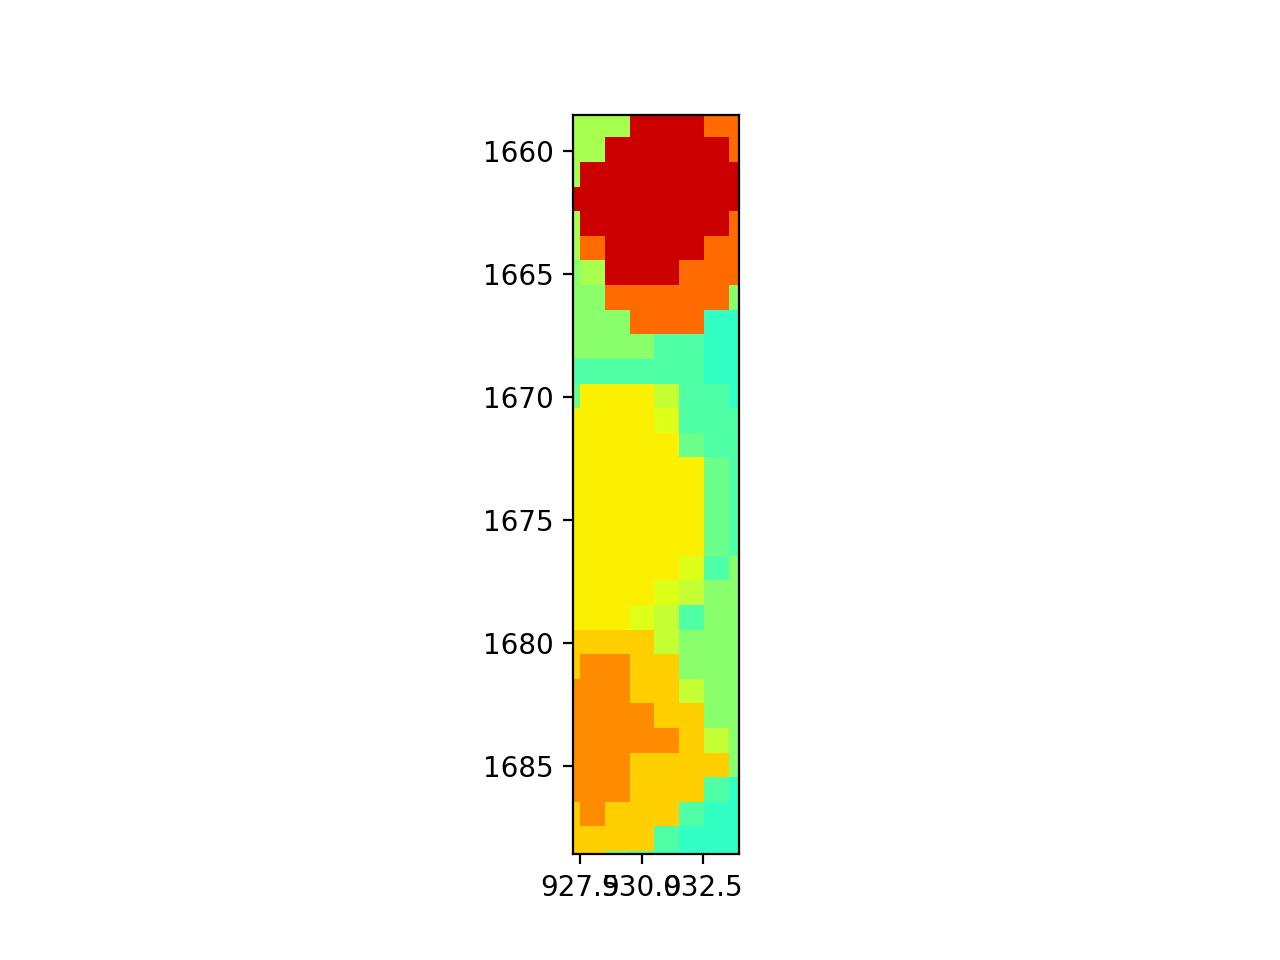

<function matplotlib.pyplot.colorbar>

In [9]:
import matplotlib.cm as cm
km=plt.figure()

base = plt.cm.get_cmap(cm.jet)
cmap=base.from_list('', base(np.linspace(0, 1, k)), k)

plt.imshow(m,cmap=cmap)
plt.colorbar